In [1]:
import tensorflow as tf
import keras

In [2]:
# Pre trained models example : VGG16, ResNet, Inception, Xception etc
# Dataset used to pre train these models : ImageNet

In [3]:
# 2 ways to utilize these pre trained models : Feature extraction and Fine tuning

In [4]:
# Convolution layers and max pooling layers : Convolutional base of the model

In [5]:
# Importing the VGG16 model
conv_base = keras.applications.vgg16.VGG16(
    weights='imagenet', # weight checkpoint from which to initialize the model
    include_top=False, # Not including the top layer i.e the Dense layer used for classification i.e the classifier
    input_shape=(180,180,3) # Optional ( if not specified, the model will be able to process inputs of any shape)
)

In [6]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

In [7]:
# The last layer i.e block5_pool has output shape of (5,5,512), which will be the output of this convolutional base 
# This will be the input of our Dense layer that we will introduce.
# 2 ways : 1. Run the convolution base over our dataset , record the outputs as a numpy array, then use this output as an input for our dense network
# 2. Extend the convolutional base with the Dense network we will create to build a model and run the images through the whole model

In [8]:
# 1st way doen't allow data augmentation, so its computationally cheap 
# 2nd way allows data augmentation, but its computationally expensive

In [9]:
# Image dataset ---> Using the previously generated dataset
import pathlib
from keras.utils import image_dataset_from_directory

new_base_dir = pathlib.Path("dogs_vs_cats_small")

train_dataset = image_dataset_from_directory(
    new_base_dir / "train", # Specifying the directory for our train folder
    image_size=(180,180),
    batch_size=32
)

validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation", # Specifying the directory for our validation folder
    image_size=(180,180),
    batch_size=32
)

test_dataset = image_dataset_from_directory(
    new_base_dir / "test", # Specifying the directory for our test folder
    image_size=(180,180),
    batch_size=32
)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [10]:
#1st method

In [11]:
import numpy as np

def get_features_and_labels(dataset):
    features_list = []
    labels_list = []
    for images, labels in dataset: # Going through each image and label pair wise in dataset
        preprocessed_images = keras.applications.vgg16.preprocess_input(images) # Preprocessing done for the images
        features = conv_base.predict(preprocessed_images) # Using the preprocessed images to get the feature outputs of the conv base of VGG16
        features_list.append(features)
        labels_list.append(labels)
    return np.concatenate(features_list),np.concatenate(labels_list)


In [12]:
train_features,train_labels = get_features_and_labels(train_dataset)
validation_features,validation_labels = get_features_and_labels(validation_dataset)
test_features,test_labels = get_features_and_labels(test_dataset)

1/1 [==============================] - 0s 22ms/step


In [13]:
train_features.shape

(2000, 5, 5, 512)

In [14]:
# Now defining our Dense connected layer

from keras.layers import Dense,Input,Flatten,Dropout
from keras.models import Model

In [15]:
input_layer = Input(shape=(5,5,512))

flatten_layer = Flatten()(input_layer)

dense_layer = Dense(256,activation="relu")(flatten_layer)
dropout_layer = Dropout(0.5)(dense_layer)

output_layer = Dense(1,activation="sigmoid")(dropout_layer)

model = Model(inputs=input_layer,outputs=output_layer) 

In [16]:
model.compile(optimizer="rmsprop",loss="binary_crossentropy",metrics="accuracy")

In [17]:
from keras.callbacks import ModelCheckpoint

callbacks_list = [ModelCheckpoint(save_best_only=True,filepath="VGG16_Feature_Extraction_without_data_augmentation",monitor="val_loss")]

In [18]:
history = model.fit(train_features,train_labels,validation_data=(validation_features,validation_labels),epochs=20,callbacks=callbacks_list)
history

Epoch 1/20
63/63 [==============================] - 3s 32ms/step - loss: 5.8022 - accuracy: 0.9205 - val_loss: 1.6676 - val_accuracy: 0.9390
Epoch 2/20
63/63 [==============================] - 2s 28ms/step - loss: 0.7411 - accuracy: 0.9680 - val_loss: 0.6420 - val_accuracy: 0.9730
Epoch 3/20
63/63 [==============================] - 1s 20ms/step - loss: 0.5596 - accuracy: 0.9805 - val_loss: 0.8816 - val_accuracy: 0.9700
Epoch 4/20
63/63 [==============================] - 1s 20ms/step - loss: 0.2605 - accuracy: 0.9880 - val_loss: 1.1643 - val_accuracy: 0.9560
Epoch 5/20
63/63 [==============================] - 2s 28ms/step - loss: 0.2253 - accuracy: 0.9895 - val_loss: 0.6058 - val_accuracy: 0.9760
Epoch 6/20
63/63 [==============================] - 1s 19ms/step - loss: 0.1435 - accuracy: 0.9945 - val_loss: 0.8676 - val_accuracy: 0.9680
Epoch 7/20
63/63 [==============================] - 1s 18ms/step - loss: 0.0869 - accuracy: 0.9935 - val_loss: 0.7751 - val_accuracy: 0.9760
Epoch 8/20
63

In [19]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

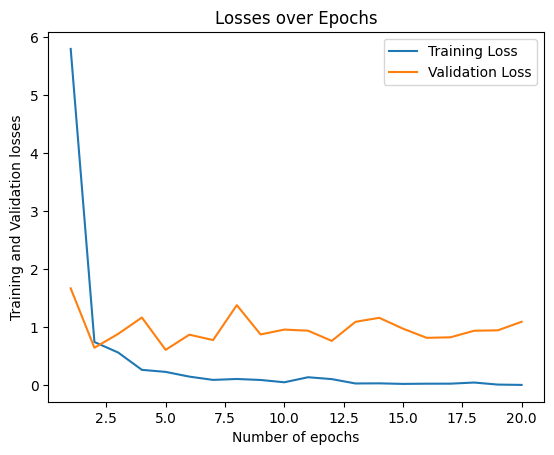

In [20]:
import matplotlib.pyplot as plt

num_epochs = range(1,len(history_dict["loss"])+1)

plt.plot(num_epochs,history_dict["loss"],label="Training Loss")
plt.plot(num_epochs,history_dict["val_loss"],label="Validation Loss")
plt.xlabel("Number of epochs")
plt.ylabel("Training and Validation losses")
plt.title("Losses over Epochs")
plt.legend()
plt.show()

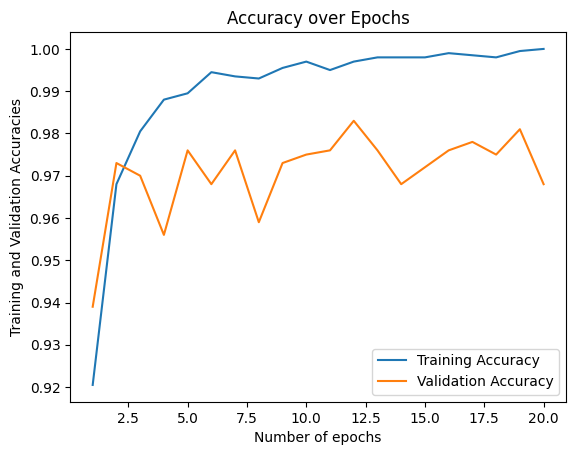

In [21]:
num_epochs = range(1,len(history_dict["loss"])+1)

plt.plot(num_epochs,history_dict["accuracy"],label="Training Accuracy")
plt.plot(num_epochs,history_dict["val_accuracy"],label="Validation Accuracy")
plt.xlabel("Number of epochs")
plt.ylabel("Training and Validation Accuracies")
plt.title("Accuracy over Epochs")
plt.legend()
plt.show()

In [22]:
# We are overfitting from almost the start, because we haven't applied any data augmentation, which is a necessery step when training over smaller dataset

In [23]:
# 2nd method

In [24]:
# We freeze the weights of the conv base , so that the previous learned representations by the pre trained conv base are not lost

In [25]:
conv_base1 = keras.applications.vgg16.VGG16(
    weights='imagenet', # weight checkpoint from which to initialize the model
    include_top=False, # Not including the top layer i.e the Dense layer used for classification i.e the classifier
    input_shape=(180,180,3), # Optional ( if not specified, the model will be able to process inputs of any shape)
)
conv_base1.trainable = False # The number of trainable weights becomes zero for the conv base 

In [26]:
len(conv_base1.trainable_weights)

0

In [27]:
# Data augmentation layer
from keras.layers import RandomFlip , RandomRotation, RandomZoom
from keras import Sequential
data_augmentation = Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.1),
    RandomZoom(0.1)
])

In [28]:
input_layer = Input(shape=(180,180,3))

data_aug_layer = data_augmentation(input_layer)
preprocess_layer = keras.applications.vgg16.preprocess_input(data_aug_layer)
conv_base_layer = conv_base1(preprocess_layer)

flatten_layer = Flatten()(conv_base_layer)
dense_layer = Dense(256,activation="relu")(flatten_layer)

dropout_layer = Dropout(0.5)(dense_layer)

output_layer = Dense(1,activation="sigmoid")(dropout_layer)

model1 = Model(inputs=input_layer,outputs=output_layer)

In [29]:
model1.compile(loss="binary_crossentropy",optimizer="rmsprop",metrics="accuracy")

In [30]:
callbacks_list1 = [ModelCheckpoint(save_best_only=True,filepath="VGG16_Feature_Extraction_with_data_augmentation",monitor="val_loss")]

In [31]:
history1 = model1.fit(train_dataset,validation_data=validation_dataset,epochs=50,callbacks=callbacks_list1)
history1

Epoch 1/50
63/63 [==============================] - ETA: 0s - loss: 5.1853 - accuracy: 0.8935WARNING:tensorflow:Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


INFO:tensorflow:Assets written to: VGG16_Feature_Extraction_with_data_augmentation\assets


INFO:tensorflow:Assets written to: VGG16_Feature_Extraction_with_data_augmentation\assets


63/63 [==============================] - 71s 1s/step - loss: 5.1853 - accuracy: 0.8935 - val_loss: 0.3933 - val_accuracy: 0.9740
Epoch 2/50
63/63 [==============================] - ETA: 0s - loss: 0.6576 - accuracy: 0.9475WARNING:tensorflow:Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


INFO:tensorflow:Assets written to: VGG16_Feature_Extraction_with_data_augmentation\assets


INFO:tensorflow:Assets written to: VGG16_Feature_Extraction_with_data_augmentation\assets


63/63 [==============================] - 64s 1s/step - loss: 0.6576 - accuracy: 0.9475 - val_loss: 0.2307 - val_accuracy: 0.9770
Epoch 3/50
63/63 [==============================] - 57s 904ms/step - loss: 0.3957 - accuracy: 0.9585 - val_loss: 0.4553 - val_accuracy: 0.9640
Epoch 4/50
63/63 [==============================] - 57s 906ms/step - loss: 0.5447 - accuracy: 0.9595 - val_loss: 0.5201 - val_accuracy: 0.9600
Epoch 5/50
63/63 [==============================] - 59s 932ms/step - loss: 0.4055 - accuracy: 0.9630 - val_loss: 0.4485 - val_accuracy: 0.9720
Epoch 6/50
63/63 [==============================] - 58s 916ms/step - loss: 0.3673 - accuracy: 0.9685 - val_loss: 0.2555 - val_accuracy: 0.9740
Epoch 7/50
63/63 [==============================] - 58s 916ms/step - loss: 0.2110 - accuracy: 0.9755 - val_loss: 0.4761 - val_accuracy: 0.9660
Epoch 8/50
63/63 [==============================] - 58s 917ms/step - loss: 0.2543 - accuracy: 0.9715 - val_loss: 0.4163 - val_accuracy: 0.9790
Epoch 9/50
63

In [32]:
history_dict1 = history1.history
history_dict1.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

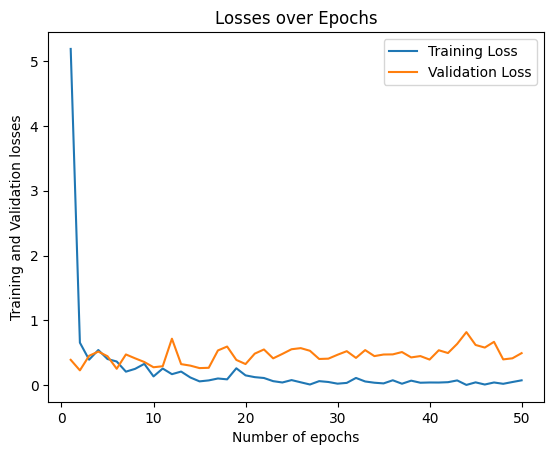

In [33]:
num_epochs = range(1,len(history_dict1["loss"])+1)

plt.plot(num_epochs,history_dict1["loss"],label="Training Loss")
plt.plot(num_epochs,history_dict1["val_loss"],label="Validation Loss")
plt.xlabel("Number of epochs")
plt.ylabel("Training and Validation losses")
plt.title("Losses over Epochs")
plt.legend()
plt.show()

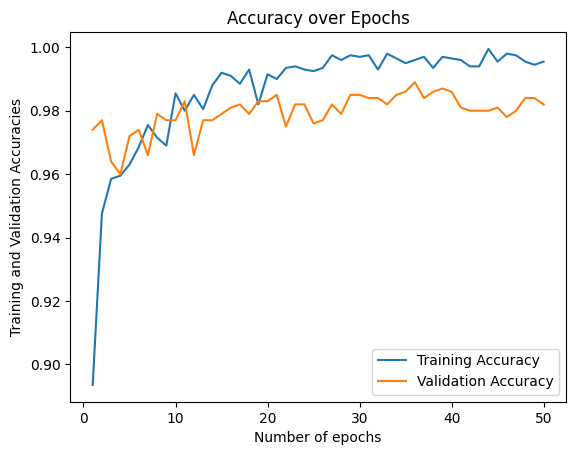

In [34]:
num_epochs = range(1,len(history_dict1["loss"])+1)

plt.plot(num_epochs,history_dict1["accuracy"],label="Training Accuracy")
plt.plot(num_epochs,history_dict1["val_accuracy"],label="Validation Accuracy")
plt.xlabel("Number of epochs")
plt.ylabel("Training and Validation Accuracies")
plt.title("Accuracy over Epochs")
plt.legend()
plt.show()

In [35]:
# Fine tuning of pretrained model

In [36]:
model1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 180, 180, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 180, 180, 3)      0         
                                                                 
 vgg16 (Functional)          (None, 5, 5, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 12800)             0         
                                                           

In [37]:
conv_base1.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

In [ ]:
# Fine tuning steps:
# 1. Load pretrained model with freeze
# 2. Add our custom dense layers
# 3. Train the whole model
# 4. Unfreeze few top conv layers(usually the last conv block) 
# 5. Retrain the last unfreezed conv layer and dense layers

In [38]:
conv_base1.trainable = True

In [39]:
conv_base1.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

In [40]:
model1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 180, 180, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 180, 180, 3)      0         
                                                                 
 vgg16 (Functional)          (None, 5, 5, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 12800)             0         
                                                           

In [41]:
conv_base1.trainable = True
for layer in conv_base1.layers[:-4]: # First 4 layers are non trainable
    layer.trainable = False


In [42]:
conv_base1.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

In [43]:
model1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 180, 180, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 180, 180, 3)      0         
                                                                 
 vgg16 (Functional)          (None, 5, 5, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 12800)             0         
                                                           

In [ ]:
# Since we have already trained the whole model, so first 3 steps done
# Now starting with step 4

In [44]:
from keras.optimizers import RMSprop

In [45]:
model1.compile(loss="binary_crossentropy", optimizer=RMSprop(learning_rate=1e-5),metrics="accuracy")# lower learning rate so that much modifications not done 

In [46]:
callbacks_list2 = [ModelCheckpoint(save_best_only=True,filepath="VGG16_Finetuning_with_data_augmentation",monitor="val_loss")]

In [47]:
history2 = model1.fit(train_dataset,validation_data=validation_dataset,epochs=30,callbacks=callbacks_list2)
history2

Epoch 1/30


63/63 [==============================] - ETA: 0s - loss: 0.4870 - accuracy: 0.9770WARNING:tensorflow:Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


INFO:tensorflow:Assets written to: VGG16_Finetuning_with_data_augmentation\assets


INFO:tensorflow:Assets written to: VGG16_Finetuning_with_data_augmentation\assets


63/63 [==============================] - 81s 1s/step - loss: 0.4870 - accuracy: 0.9770 - val_loss: 0.3662 - val_accuracy: 0.9820
Epoch 2/30
63/63 [==============================] - 49s 772ms/step - loss: 0.1792 - accuracy: 0.9810 - val_loss: 0.3667 - val_accuracy: 0.9850
Epoch 3/30
63/63 [==============================] - ETA: 0s - loss: 0.2586 - accuracy: 0.9845WARNING:tensorflow:Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


INFO:tensorflow:Assets written to: VGG16_Finetuning_with_data_augmentation\assets


INFO:tensorflow:Assets written to: VGG16_Finetuning_with_data_augmentation\assets


63/63 [==============================] - 37s 587ms/step - loss: 0.2586 - accuracy: 0.9845 - val_loss: 0.3039 - val_accuracy: 0.9840
Epoch 4/30
63/63 [==============================] - 30s 476ms/step - loss: 0.1180 - accuracy: 0.9865 - val_loss: 0.3054 - val_accuracy: 0.9820
Epoch 5/30
63/63 [==============================] - 31s 491ms/step - loss: 0.1274 - accuracy: 0.9900 - val_loss: 0.3155 - val_accuracy: 0.9830
Epoch 6/30
63/63 [==============================] - 31s 490ms/step - loss: 0.0933 - accuracy: 0.9890 - val_loss: 0.3409 - val_accuracy: 0.9810
Epoch 7/30
63/63 [==============================] - ETA: 0s - loss: 0.0696 - accuracy: 0.9900WARNING:tensorflow:Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


INFO:tensorflow:Assets written to: VGG16_Finetuning_with_data_augmentation\assets


INFO:tensorflow:Assets written to: VGG16_Finetuning_with_data_augmentation\assets


63/63 [==============================] - 39s 620ms/step - loss: 0.0696 - accuracy: 0.9900 - val_loss: 0.2764 - val_accuracy: 0.9830
Epoch 8/30
63/63 [==============================] - 32s 504ms/step - loss: 0.0497 - accuracy: 0.9930 - val_loss: 0.3840 - val_accuracy: 0.9800
Epoch 9/30
63/63 [==============================] - 31s 499ms/step - loss: 0.0462 - accuracy: 0.9910 - val_loss: 0.2970 - val_accuracy: 0.9830
Epoch 10/30
63/63 [==============================] - 31s 499ms/step - loss: 0.0662 - accuracy: 0.9920 - val_loss: 0.3437 - val_accuracy: 0.9810
Epoch 11/30
63/63 [==============================] - 31s 499ms/step - loss: 0.0208 - accuracy: 0.9950 - val_loss: 0.3889 - val_accuracy: 0.9820
Epoch 12/30
63/63 [==============================] - 32s 514ms/step - loss: 0.0209 - accuracy: 0.9970 - val_loss: 0.2948 - val_accuracy: 0.9850
Epoch 13/30
63/63 [==============================] - ETA: 0s - loss: 0.0563 - accuracy: 0.9940WARNING:tensorflow:Using a while_loop for converting Rng

INFO:tensorflow:Assets written to: VGG16_Finetuning_with_data_augmentation\assets


INFO:tensorflow:Assets written to: VGG16_Finetuning_with_data_augmentation\assets


63/63 [==============================] - 40s 637ms/step - loss: 0.0563 - accuracy: 0.9940 - val_loss: 0.2394 - val_accuracy: 0.9830
Epoch 14/30
63/63 [==============================] - 32s 509ms/step - loss: 0.0112 - accuracy: 0.9970 - val_loss: 0.2408 - val_accuracy: 0.9860
Epoch 15/30
63/63 [==============================] - 32s 504ms/step - loss: 0.0128 - accuracy: 0.9995 - val_loss: 0.3405 - val_accuracy: 0.9840
Epoch 16/30
63/63 [==============================] - 32s 506ms/step - loss: 0.0264 - accuracy: 0.9960 - val_loss: 0.2591 - val_accuracy: 0.9820
Epoch 17/30
63/63 [==============================] - 32s 506ms/step - loss: 0.0258 - accuracy: 0.9955 - val_loss: 0.2755 - val_accuracy: 0.9840
Epoch 18/30
63/63 [==============================] - 32s 506ms/step - loss: 0.0089 - accuracy: 0.9970 - val_loss: 0.2699 - val_accuracy: 0.9860
Epoch 19/30
63/63 [==============================] - 32s 507ms/step - loss: 0.0103 - accuracy: 0.9985 - val_loss: 0.2621 - val_accuracy: 0.9860
Epoc

In [48]:
history_dict2 = history2.history
history_dict2.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

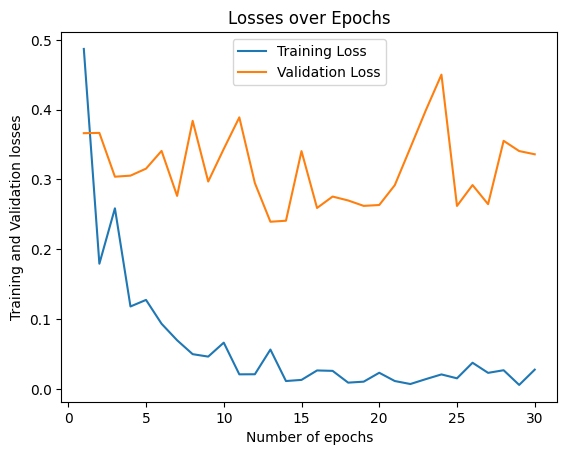

In [49]:
num_epochs = range(1,len(history_dict2["loss"])+1)

plt.plot(num_epochs,history_dict2["loss"],label="Training Loss")
plt.plot(num_epochs,history_dict2["val_loss"],label="Validation Loss")
plt.xlabel("Number of epochs")
plt.ylabel("Training and Validation losses")
plt.title("Losses over Epochs")
plt.legend()
plt.show()

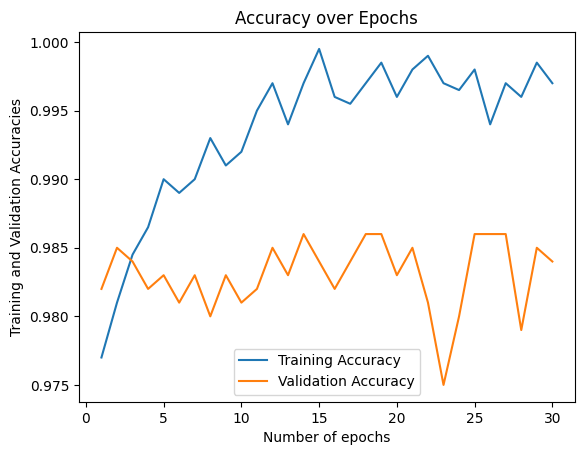

In [50]:
num_epochs = range(1,len(history_dict2["loss"])+1)

plt.plot(num_epochs,history_dict2["accuracy"],label="Training Accuracy")
plt.plot(num_epochs,history_dict2["val_accuracy"],label="Validation Accuracy")
plt.xlabel("Number of epochs")
plt.ylabel("Training and Validation Accuracies")
plt.title("Accuracy over Epochs")
plt.legend()
plt.show()

In [51]:
# Comparing the test accuracy results for all the models

In [53]:
# Best models from all the 3 cases are loaded here
model_1 = keras.models.load_model("VGG16_Feature_Extraction_without_data_augmentation")
model_2 = keras.models.load_model("VGG16_Feature_Extraction_with_data_augmentation")
model_3 = keras.models.load_model("VGG16_Finetuning_with_data_augmentation")

In [56]:
model_1.evaluate(test_features,test_labels) # The inputs are created using make_subset function defined earlier

63/63 [==============================] - 0s 5ms/step - loss: 0.5785 - accuracy: 0.9765


[0.5784660577774048, 0.9764999747276306]

In [57]:
model_2.evaluate(train_dataset)

63/63 [==============================] - 7s 110ms/step - loss: 0.1298 - accuracy: 0.9895


[0.1297948658466339, 0.9894999861717224]

In [58]:
model_3.evaluate(train_dataset)

63/63 [==============================] - 7s 109ms/step - loss: 0.0019 - accuracy: 0.9995


[0.0019276790553703904, 0.9994999766349792]

In [59]:
# Test Accuracy highest after fine tuning the model